# Submisson Details

Submitted By - Brihi Joshi
Roll Number - 2016142

*All the comments are added as Markdown comments and the report is generated by rendering this Jupyter Notebook to a LaTeX project.*

In [1]:
import librosa
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa.display as ld

import IPython.display as ipd

### The Audio I recorded says - He is a boy.

In [2]:
xn, sr = librosa.load('recordings/recording1.wav')

In [3]:
xn.shape

(104429,)

In [6]:
sr

22050

# Annotations

All of the following annotations are in seconds

1. 0.6-0.9 - h (unvoiced phoneme)
2. 0.9-1.4 - ee
3. 1.8-2.4 - i
4. 2.4-2.6 - z (voiced phoneme)
5. 2.9-3.4 - a
6. 3.6-4 - b (voiced phoneme)
7. 4-4.3 - au
8. 4.3-4.5 - ae


In [8]:
ipd.Audio('recordings/recording1.wav') 

# 1. To Analyse the Sound Spectrogram

### a. Custom DFT and STFT

In the following code, I will demonstrate that the spectrogram obtained from my DFT + STFT implementations looks similar to that by library implementations of FFT and STFT with the same parameters

In [9]:
def dft_custom(xn):
    N = xn.shape[0]
    e_matrix = np.fromfunction(lambda m, n: np.exp(-(2*np.pi*m*n*1j)/N), (N, N))
    return e_matrix.dot(xn)

In [10]:
def stft(xn, window_size = None, hopsize= 512, window = 'hamming', fft_size = 512):
    total_samples = xn.shape[0]
    
    if window_size == None:
        window_size = fft_size
    
    if hopsize == None:
        hopsize = int(fft_size/4)

    
    # Getting window of size window_size
    window_fn = sp.signal.get_window(window, Nx=fft_size)
    
    start_index = 0 - hopsize
    end_index = window_size - hopsize
    
    stft_res = []
    
    
    counter = 0
    while start_index + hopsize <= total_samples - window_size:
        start_index = start_index + hopsize
        end_index = end_index + hopsize
        
        x_window = xn[start_index:end_index]
        
        
        # x_window is of window_size. Need to pad it to fft_size
        diff = fft_size - window_size
        
        if diff %2==0:
            
            x_window = np.pad(x_window, (int(diff/2), (int(diff/2))))
            
        else:
            
            x_window = np.pad(x_window, (int(diff/2), (int(diff/2)+1)))
        
        
        try:
        
            mult_window = x_window * window_fn
        
        except:
            print(start_index)
            print(end_index)
                    
        dft_window = dft_custom(mult_window)[:int(fft_size/2)+1]
        
        stft_res.append(dft_window)
        
#         print(counter)
        counter+=1
    
    return np.array(stft_res)
            

In [11]:
res = stft(xn,window_size =500, hopsize = int(500/4))

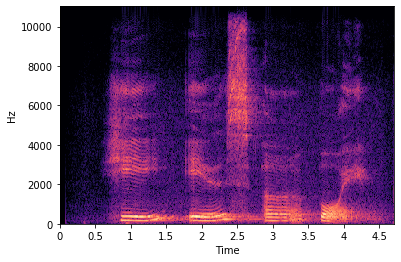

In [12]:
ld.specshow(librosa.amplitude_to_db(np.abs(res.T),ref=np.max), hop_length=int(500/4),y_axis='linear', x_axis='time')
plt.savefig('my_stft_dft_recording1.png')

In [13]:
res.shape

(832, 257)

In the spectrogram above, while keeping the annotations in mind, the following things are observed:

1. Vowels have a large number of (high amplitude) low frequencies, making them visually distinguishable
2. Voiced phonemes like 'z' and 'b' have a **range** of frequencies, which makes them distinguishable. Viewing them in the spectrogram demonstrates that too.
3. Unvoiced phonemes like 'h' are difficult to distinguish in the spectrogram (the results for which can also be observed in the clustering experiment below)

### b. FFT with STFT

In [14]:
def stft_fft(xn, window_size = None, hopsize= 512, window = 'hamming', fft_size = 512):
    total_samples = xn.shape[0]
    
    if window_size == None:
        window_size = fft_size
    
    if hopsize == None:
        hopsize = int(fft_size/4)

    
    # Getting window of size window_size
    window_fn = sp.signal.get_window(window, Nx=fft_size)
    
    start_index = 0 - hopsize
    end_index = window_size - hopsize
    
    stft_res = []
    
    
    counter = 0
    while start_index + hopsize <= total_samples - window_size:
        start_index = start_index + hopsize
        end_index = end_index + hopsize
        
        x_window = xn[start_index:end_index]
        
        
        # x_window is of window_size. Need to pad it to fft_size
        diff = fft_size - window_size
        
        if diff %2==0:
            
            x_window = np.pad(x_window, (int(diff/2), (int(diff/2))))
            
        else:
            
            x_window = np.pad(x_window, (int(diff/2), (int(diff/2)+1)))
        
        
        try:
        
            mult_window = x_window * window_fn
        
        except:
            print(start_index)
            print(end_index)
        
        dft_window = np.fft.fft(mult_window)[:int(fft_size/2)+1]
        
        stft_res.append(dft_window)
        
#         print(counter)
        counter+=1
    
    return np.array(stft_res)
            

In [15]:
res_stft = stft_fft(xn,window_size =500, hopsize = int(500/4))

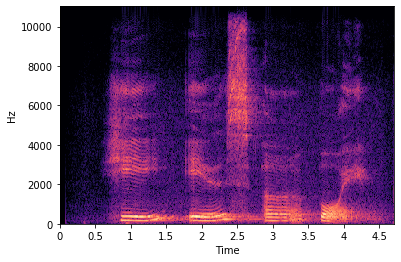

In [16]:
ld.specshow(librosa.amplitude_to_db(np.abs(res_stft.T),ref=np.max), hop_length=int(500/4),y_axis='linear', x_axis='time')
plt.savefig('my_stft_fft_recording1.png')

In [17]:
res_stft.shape

(832, 257)

### c. Librosa Implementation

In [18]:
D_short = np.abs(librosa.stft(xn, hop_length=int(500/4), window='hamming', n_fft=512, win_length=500, center=False))

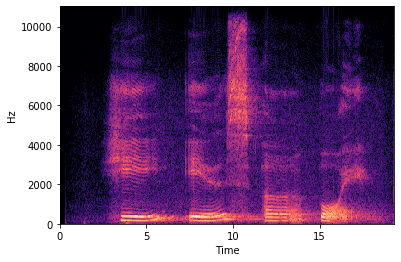

In [19]:
ld.specshow(librosa.amplitude_to_db(D_short,ref=np.max), y_axis='linear', x_axis='time')
plt.savefig('librosa_stft_recording1.png')

In [20]:
D_short.shape

(257, 832)

# 2. MFCC

In [21]:
def preemphasis(xn, alpha = 0.97):
    # Using pre-empaphases with a certain alpha
    pre_e_xn = np.zeros((xn.shape))
    
    pre_e_xn[0] = xn[0]
    
    pre_e_xn[1:] = xn[1:] - alpha * xn[:-1]
    
    return pre_e_xn

In [22]:
def get_mel_from_hertz(hertz):
    return 2595 * np.log10(1 + (hertz/ 700))

In [23]:
def get_hertz_from_mel(mel):
    return 700 * (10**(mel / 2595) - 1)

In [24]:
def get_power_spectrum(xn_mag, fft_size=2048):
    return (1/fft_size) * np.power(xn_mag, 2)
    

In [25]:
def mel_filter_banks(xn_pow, sr, number_filters, fft_size=2048):
    min_mel = 0
    max_mel = get_mel_from_hertz(sr/2)
    
    mel_freq_points = np.linspace(min_mel, max_mel, num=number_filters+2)
    hertz_freq_points = get_hertz_from_mel(mel_freq_points)
    
    corresponding_bins_hertz_points = np.floor((fft_size + 1) * hertz_freq_points / sr)
    
    # Filter banks have to be of shape number_filters * (fft_size/2) + 1
    filter_banks = np.zeros((number_filters, int(fft_size/2)+1))
    
    for bin_fb in range(1, number_filters+1):
        
        prev_bin = corresponding_bins_hertz_points[bin_fb-1]
        current_bin = corresponding_bins_hertz_points[bin_fb]
        next_bin = corresponding_bins_hertz_points[bin_fb+1]
        
        # Use the triangle function to get the values of the banks
        
        for b in range(int(prev_bin), int(current_bin)):
            filter_banks[bin_fb-1, b] = (b - prev_bin) / (current_bin - prev_bin)
            
        for b in range(int(current_bin)+1, int(next_bin)):
            
            filter_banks[bin_fb-1, b] = (next_bin - b) / (next_bin - current_bin)
            
        filter_banks[bin_fb-1, int(current_bin)] = 1
        
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    return filter_banks
    

In [26]:
def get_delta_values(x):
    delta_x = np.zeros(shape=x.shape)
    for i in range(1,x.shape[1]-1):
        prev_val = x[:,i-1]
        next_val = x[:,i+1]
        
        delta_x[:,i]  = (next_val - prev_val)/2
    
    return delta_x

In [27]:
def mfcc(xn, sr, number_filters, window_size = 500, hopsize=int(500/4), fft_size=512):
    
    # Pre-emphasis
    
    xn = preemphasis(xn)
    
    # Getting the STFT
        
    xn_stft = stft(xn, window_size= window_size, hopsize=hopsize, fft_size=fft_size)
    
    # Getting the Magnitude of the STFT
    
    xn_mag = np.abs(xn_stft)
    
    # Evaluating the Power spectrum for the magnitude
    
    xn_pow = get_power_spectrum(xn_mag, fft_size=fft_size)
    
    # To get the mel filter banks
    
    filter_banks = mel_filter_banks(xn_pow, sr, number_filters, fft_size=fft_size)
    
    
    # Multiply the filter_banks with the power spectrum
    
    filter_banks_res = np.dot(filter_banks, xn_pow.T)
    
    # Taking the log and the inverse DFT
    
    log_filter_bank = np.log(filter_banks_res+np.finfo(float).eps)
    
    idft = sp.fftpack.dct(log_filter_bank)
    
    # First 12 MFCC Values
    
    first_12 = idft[:12,:]
    
    # delta and delta-delta coefficients
    
    delta = get_delta_values(idft)
    
    delta_delta = get_delta_values(delta)
    
    # Getting Energy values of delta and delta-delta coefficients
    
    first_12_delta = delta[:12,:]
    
    first_12_delta_delta = delta_delta[:12,:]
    
    
    # Energy of the Cepstrum frame. Read from - http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.596.8754&rep=rep1&type=pdf
    
    energy = np.sqrt(np.sum(np.power(first_12,2),axis=0)).reshape(1,-1)
    
    energy_delta = np.sqrt(np.sum(np.power(first_12_delta,2),axis=0)).reshape(1,-1)
    
    energy_delta_delta = np.sqrt(np.sum(np.power(first_12_delta_delta,2),axis=0)).reshape(1,-1)
    
    return np.vstack((energy, energy_delta, energy_delta_delta, first_12, first_12_delta, first_12_delta_delta)), filter_banks

In [28]:
mfcc_xn, filter_banks = mfcc(xn, sr, 40)

The Implemented Mel Filterbanks look like the following

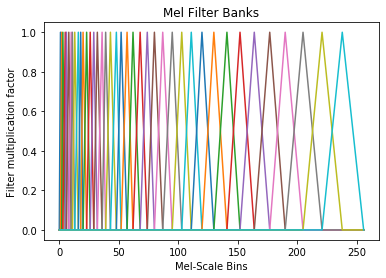

In [29]:
plt.plot(filter_banks.T)
plt.ylabel("Filter multiplication factor")
plt.xlabel("Mel-Scale Bins")
plt.title("Mel Filter Banks")
plt.savefig("mel_filter_banks.png")
plt.show()

Looking at the Cepstral Coefficients, We can see the a small peak is being formed at around the **16th** sample. This shows that the F0 is present athere who's amplitude is around 5000. For ASR Purposes, we only take the first 12 cepstral coefficients

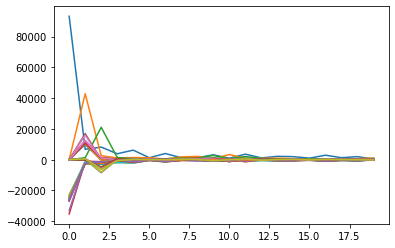

In [30]:
plt.plot(mfcc_xn.T[:20])
plt.show()

# 3. Clustering

In this experiment, I have conducted the following steps - 

1. Spoken 2 examples of vowels and consonants each
2. Taken out MFCC Features of the 4 sound samples

Reading the vowels

In [32]:
aa, sr = librosa.load('consonants_vowels/Aa.wav')

In [33]:
ee, sr = librosa.load('consonants_vowels/Ee.wav')

Reading the consonants

In [34]:
r, sr = librosa.load('consonants_vowels/R.wav')

In [35]:
sh, sr = librosa.load('consonants_vowels/Sh.wav')

### Calculating MFCC features of the consonants and vowels

In [36]:
aa_mfcc = mfcc(aa, sr, 40)[0]

ee_mfcc = mfcc(ee, sr, 40)[0]

r_mfcc = mfcc(r, sr, 40)[0]

sh_mfcc = mfcc(sh, sr, 40)[0]

In [37]:
def get_avg_mfcc(mfcc_vector):
    return np.mean(mfcc_vector, axis=1)

In [38]:
aa_mfcc = get_avg_mfcc(aa_mfcc)
ee_mfcc = get_avg_mfcc(ee_mfcc)
r_mfcc = get_avg_mfcc(r_mfcc)
sh_mfcc = get_avg_mfcc(sh_mfcc)

In [39]:
features = np.vstack((aa_mfcc, ee_mfcc, r_mfcc, sh_mfcc))

In [40]:
features.shape

(4, 39)

Running K Means clustering over the consonant and vowels

In [41]:
from sklearn.cluster import KMeans

In [43]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(features)

In [44]:
kmeans.labels_

array([0, 0, 0, 1], dtype=int32)

These labels imply that aa, ee, and r are in the same cluster, but sh is not in the same cluster

## Analysis

The experimentation done above was done for 4 different vowels and 5 different consonants. A repeated pattern that was observed was that - 

**All Vowels were in the same cluster, but all consonants were never clustered together**. This can be because *within consonants*, the pronounciation differs for a lot of the consonants (voiced, unvoiced, and other distinctions), making the MFCC features robust enough to understand these features.